In [21]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score

In [2]:
d = pd.read_csv('data/Howell1.csv', sep=';')

In [3]:
d2 = d[d['age'] >= 18]

In [4]:
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


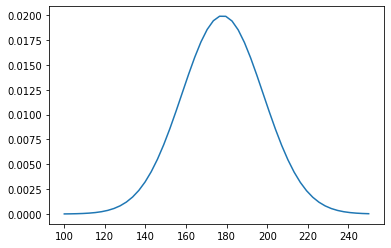

In [5]:
x = jnp.linspace(100, 250)
mu_ = jnp.exp(dist.Normal(178, 20).log_prob(x))
plt.plot(x, mu_)

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/distributions/distribution.py:292: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  warnings.warn(


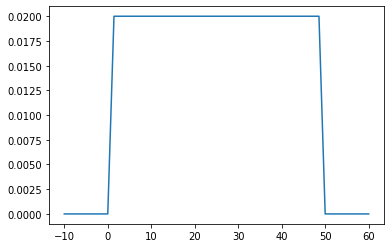

In [6]:
x = jnp.linspace(-10, 60)
sigma_ = jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x))
plt.plot(x, sigma_)

In [7]:
rng_key = random.PRNGKey(0)
keys = random.split(rng_key, 3)
sample_mu = dist.Normal(178, 20).sample(keys[0], (10000,))
sample_sigma = dist.Uniform(0, 50).sample(keys[1], (10000,))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(keys[2])

#plt.hist(prior_h, bins = 50)

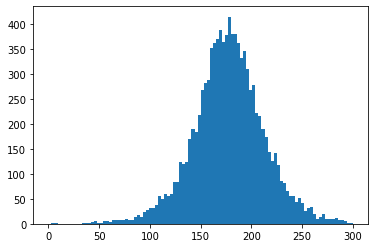

In [8]:
_ = plt.hist(prior_h, bins = 100, range=[0,300])

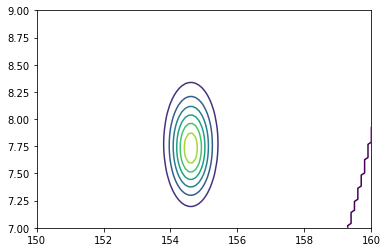

In [28]:
# Grid approximation pf posterior for heright regression example

mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mu, sigma = jnp.meshgrid(mu_list, sigma_list)
mu = mu.reshape(-1)
sigma = sigma.reshape(-1)
y = jnp.array(d2['height'])
mu_prior = dist.Normal(178, 20)
sigma_prior = dist.Uniform(0,50)

def unscaled_posterior_log(mu, sigma):
    log_likelihood = dist.Normal(mu, sigma).log_prob(y).sum()
    log_prior_prob = mu_prior.log_prob(mu) + sigma_prior.log_prob(sigma)
    return log_likelihood + log_prior_prob


post = jax.vmap(unscaled_posterior_log, in_axes=0)(mu, sigma)
post_max_1 = jnp.exp(post - max(post))
scaled_posterior = post_max_1 / post_max_1.sum()

plt.contour(mu.reshape(100, 100)
            ,sigma.reshape(100, 100)
            ,scaled_posterior.reshape((100, 100)))


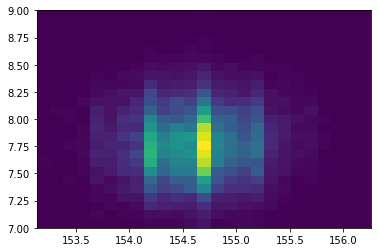

In [29]:
# Sample from posterior
samples = dist.CategoricalProbs(probs=scaled_posterior).sample(rng_key,(20000,))
# row, column = jnp.divmod(samples,100)
# _ = plt.hist2d(mu_list[row], sigma_list[column], bins =25)

_ = plt.hist2d(mu[samples], sigma[samples], bins =25)

<AxesSubplot:>

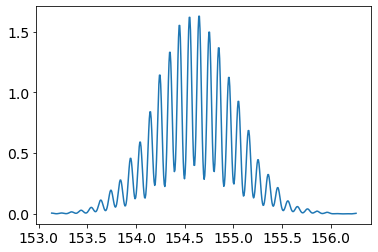

In [30]:
az.plot_kde(mu[samples])

<AxesSubplot:>

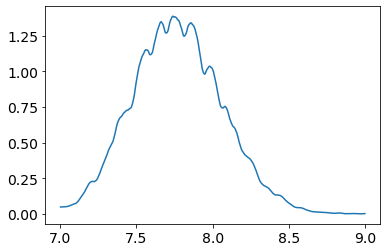

In [31]:
az.plot_kde(sigma[samples])

In [32]:
print(
    az.stats.hdi(np.array(mu[samples]), hdi_prob=0.89)
    ,az.stats.hdi(np.array(sigma[samples]), hdi_prob=0.89)
)

[154.0404  155.35353] [7.3030305 8.232323 ]


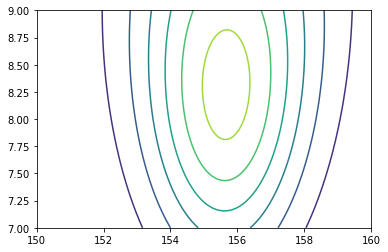

In [39]:
# Repeat all that with sample of only 20 heights

mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mu, sigma = jnp.meshgrid(mu_list, sigma_list)
mu = mu.reshape(-1)
sigma = sigma.reshape(-1)
y = jnp.array(d2['height'].sample(20))
mu_prior = dist.Normal(178, 20)
sigma_prior = dist.Uniform(0,50)

def unscaled_posterior_log(mu, sigma):
    log_likelihood = dist.Normal(mu, sigma).log_prob(y).sum()
    log_prior_prob = mu_prior.log_prob(mu) + sigma_prior.log_prob(sigma)
    return log_likelihood + log_prior_prob


post = jax.vmap(unscaled_posterior_log, in_axes=0)(mu, sigma)
post_max_1 = jnp.exp(post - max(post))
scaled_posterior = post_max_1 / post_max_1.sum()

plt.contour(mu.reshape(100, 100)
            ,sigma.reshape(100, 100)
            ,scaled_posterior.reshape((100, 100)))

# Sample from posterior
samples = dist.CategoricalProbs(probs=scaled_posterior).sample(rng_key,(20000,))
_ = plt.hist2d(mu[samples], sigma[samples], bins =25)
#az.plot_kde(sigma[samples])

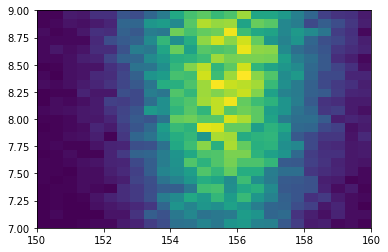

In [43]:
_ = plt.hist2d(mu[samples], sigma[samples], bins =25)

<AxesSubplot:>

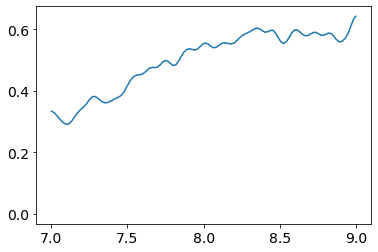

In [44]:
az.plot_kde(sigma[samples])

In [47]:
def model(height):
    mu = numpyro.sample("mu", mu_prior)
    sigma = numpyro.sample("sigma", sigma_prior)
    obs = numpyro.sample("obs", dist.Normal(mu, sigma), obs=height)

In [49]:
from numpyro.infer.autoguide import AutoLaplaceApproximation

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, jnp.array(d2['height']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)


100%|██████████| 10000/10000 [00:02<00:00, 3526.52it/s, init loss: 4000.1152, avg. loss [9501-10000]: 1226.2153]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu    154.58      0.42    154.58    153.88    155.27   9926.97      1.00
     sigma      7.94      0.31      7.93      7.43      8.45   9502.41      1.00



In [51]:
jnp.cov(jnp.stack([samples['mu'], samples['sigma']]))

DeviceArray([[ 0.17880431, -0.00025148],
             [-0.00025148,  0.09449609]], dtype=float32)

<AxesSubplot:xlabel='weight', ylabel='height'>

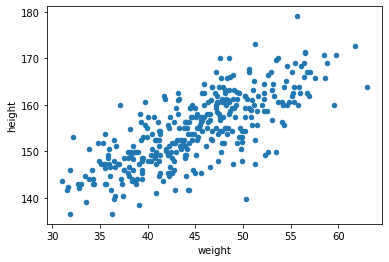

In [60]:
d2.plot.scatter('weight', 'height')

In [69]:
n = 100
with numpyro.handlers.seed(rng_seed=1):
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50).expand((n,)))
    beta = numpyro.sample("beta", dist.Normal(0, 10).expand((n,)))
    alpha = numpyro.sample("alpha", dist.Normal(178, 20).expand((n,)))


In [90]:
x = jnp.linspace(30, 65)
x_bar = d2['weight'].mean()
x_diff = x - x_bar
y = alpha + beta*jnp.tile(x_diff,(n,1)).T

Text(0, 0.5, 'height')

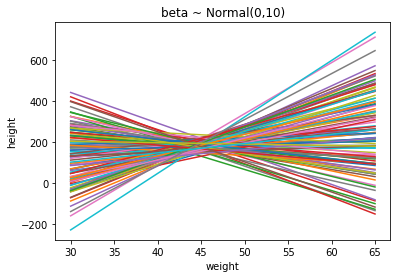

In [92]:
y.shape
for i in range(y.shape[1]):
    plt.plot(x, y[:,i])
plt.title('beta ~ Normal(0,10)')
plt.xlabel('weight')
plt.ylabel('height')


Text(0, 0.5, 'height')

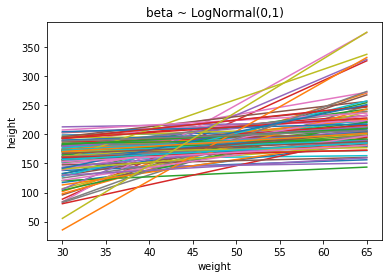

In [94]:
beta = numpyro.sample("beta", dist.LogNormal(0, 1).expand((n,)), rng_key=random.PRNGKey(42))
x = jnp.linspace(30, 65)
x_bar = d2['weight'].mean()
x_diff = x - x_bar
y = alpha + beta*jnp.tile(x_diff,(n,1)).T
y.shape
for i in range(y.shape[1]):
    plt.plot(x, y[:,i])
plt.title('beta ~ LogNormal(0,1)')
plt.xlabel('weight')
plt.ylabel('height')

In [142]:
mean_weight = x_bar
def model(weight, height=None):

    # priors
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    beta = numpyro.sample("beta", dist.LogNormal(0, 1))
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))

    # regression
    #mean_weight = weight.mean()
    mean_height = numpyro.deterministic("mean_height", alpha + beta*(weight - mean_weight))

    obs = numpyro.sample("obs", dist.Normal(mean_height, sigma), obs=height)

In [143]:
from numpyro.infer.autoguide import AutoLaplaceApproximation

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, jnp.array(d2['weight']), jnp.array(d2['height']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:02<00:00, 3892.58it/s, init loss: 7323.5054, avg. loss [9501-10000]: 1079.3025]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha    154.56      0.28    154.57    154.09    155.00   9971.53      1.00
            beta      0.95      0.04      0.94      0.88      1.01  10055.46      1.00
  mean_height[0]    157.25      0.30    157.25    156.75    157.73   9935.22      1.00
  mean_height[1]    146.52      0.45    146.52    145.75    147.22  10090.81      1.00
  mean_height[2]    142.15      0.61    142.16    141.18    143.17  10094.32      1.00
  mean_height[3]    162.18      0.43    162.18    161.49    162.89   9953.86      1.00
  mean_height[4]    151.05      0.32    151.05    150.54    151.57  10049.90      1.00
  mean_height[5]    171.59      0.80    171.58    170.31    172.90  10000.33      1.00
  mean_height[6]    148.18      0.39    148.18    147.55    148.84  10083.17      1.00
  mean_height[7]    164.49      0.52    164.48    163.68    165.34   9969.00      1.00
  mean_height[8]    144.99      0.50    14

In [144]:
jnp.cov(jnp.stack([samples['alpha'], samples['beta'], samples['sigma']]))**0.5

DeviceArray([[0.27692237, 0.00105315, 0.0281118 ],
             [0.00105315, 0.04154695, 0.0254546 ],
             [0.0281118 , 0.0254546 , 0.1970698 ]], dtype=float32)

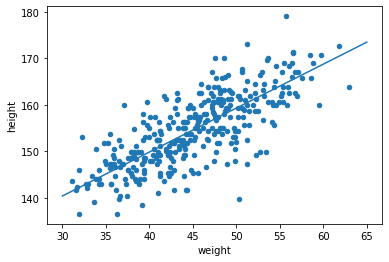

In [145]:
ax = d2.plot.scatter('weight', 'height')
ax.plot(x, samples['alpha'].mean() + samples['beta'].mean()*(x-d2['weight'].mean()))

In [146]:
_predictive = Predictive(model, samples, return_sites=['mean_height', 'obs'])
pred = _predictive(random.PRNGKey(2), x, None)


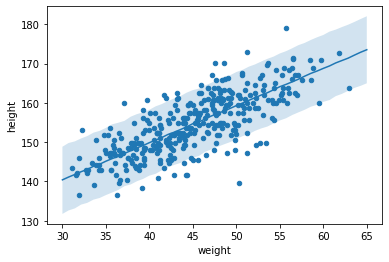

In [158]:
loc = pred['obs'].mean(axis=0)
low, high = jnp.percentile(pred['obs'], jnp.array([5.0, 95.0]), axis=0)
ax = d2.plot.scatter('weight', 'height')
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)


## Section 4.5

<AxesSubplot:xlabel='weight', ylabel='height'>

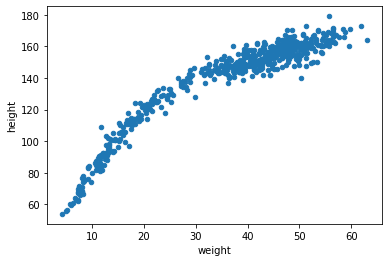

In [159]:
d.plot.scatter('weight', 'height')

In [161]:
avg_weight = d['weight'].mean()
std_weight = d['weight'].std()
norm_weight = jnp.array((d['weight'] - avg_weight)  /std_weight)
def get_height(norm_weight):
    return norm_weight * std_weight + avg_weight

In [172]:
def model(weight, height=None):

    # priors
    sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", dist.Normal(0, 1))
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))

    # regression
    mean_height = numpyro.deterministic("mean_height", alpha + beta1*weight + beta2*weight**2)

    obs = numpyro.sample("obs", dist.Normal(mean_height, sigma), obs=height)

In [173]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, norm_weight, jnp.array(d['height']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:07<00:00, 1308.37it/s, init loss: 180954.8281, avg. loss [9501-10000]: 1772.0135]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha    146.04      0.37    146.05    145.45    146.67   9990.21      1.00
           beta1     22.22      0.29     22.22     21.74     22.69   9138.91      1.00
           beta2     -7.82      0.28     -7.83     -8.27     -7.36   9775.90      1.00
  mean_height[0]    159.10      0.32    159.10    158.54    159.61   9449.17      1.00
  mean_height[1]    147.34      0.37    147.34    146.72    147.92  10019.96      1.00
  mean_height[2]    139.88      0.39    139.89    139.21    140.52   9876.75      1.00
  mean_height[3]    161.39      0.48    161.39    160.64    162.21   8765.71      1.00
  mean_height[4]    153.44      0.32    153.44    152.94    153.99  10072.26      1.00
  mean_height[5]    160.31      1.09    160.31    158.51    162.08   8823.18      1.00
  mean_height[6]    149.77      0.35    149.77    149.16    150.31  10064.39      1.00
  mean_height[7]    161.79      0.60    16

In [179]:
x = jnp.linspace(0, 65)
norm_x = ( x - avg_weight ) / std_weight
_predictive = Predictive(model, samples, return_sites=['obs'])
pred = _predictive(random.PRNGKey(3), norm_x, None)

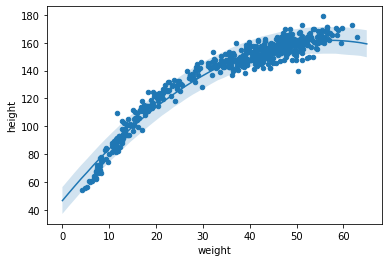

In [180]:
loc = pred['obs'].mean(axis=0)
low, high = jnp.percentile(pred['obs'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('weight', 'height')
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)

In [181]:
def model(weight, height=None):

    # priors
    sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
    beta1 = numpyro.sample("beta1", dist.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", dist.Normal(0, 1))
    beta3 = numpyro.sample("beta3", dist.Normal(0, 1))
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))

    # regression
    mean_height = numpyro.deterministic("mean_height", alpha + beta1*weight + beta2*weight**2 + beta3*weight**3)

    obs = numpyro.sample("obs", dist.Normal(mean_height, sigma), obs=height)

In [182]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 10000, norm_weight, jnp.array(d['height']))
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

100%|██████████| 10000/10000 [00:02<00:00, 3533.34it/s, init loss: 172218.9688, avg. loss [9501-10000]: 1875.2284]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha    145.50      0.62    145.50    144.43    146.48  10110.24      1.00
           beta1     15.89      0.93     15.87     14.41     17.46   9655.12      1.00
           beta2     -5.35      0.48     -5.35     -6.11     -4.54   9832.02      1.00
           beta3      3.48      0.43      3.48      2.78      4.20   9895.26      1.00
  mean_height[0]    156.99      0.61    156.99    155.99    158.01   9397.90      1.00
  mean_height[1]    146.43      0.61    146.43    145.37    147.38  10088.85      1.00
  mean_height[2]    141.05      0.70    141.05    139.93    142.24  10133.46      1.00
  mean_height[3]    162.59      0.82    162.60    161.24    163.95   9341.37      1.00
  mean_height[4]    151.02      0.58    151.01    150.05    151.98   9896.55      1.00
  mean_height[5]    178.96      2.69    178.95    174.62    183.39   9798.31      1.00
  mean_height[6]    148.19      0.59    14

In [183]:
x = jnp.linspace(0, 65)
norm_x = ( x - avg_weight ) / std_weight
_predictive = Predictive(model, samples, return_sites=['obs'])
pred = _predictive(random.PRNGKey(3), norm_x, None)

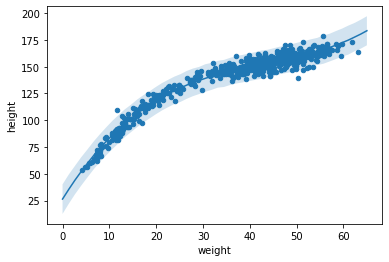

In [184]:
loc = pred['obs'].mean(axis=0)
low, high = jnp.percentile(pred['obs'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('weight', 'height')
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)

In [188]:
d = pd.read_csv('data/cherry_blossoms.csv', sep=';')

In [189]:
d.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [190]:
d.sample(5)

,year,doy,temp,temp_upper,temp_lower
436,1237,NaN,6.09,7.31,4.87
470,1271,100.0,6.14,6.97,5.32
936,1737,93.0,5.94,6.69,5.18
902,1703,103.0,5.70,6.33,5.08
568,1369,94.0,6.66,7.32,5.99


<AxesSubplot:xlabel='year'>

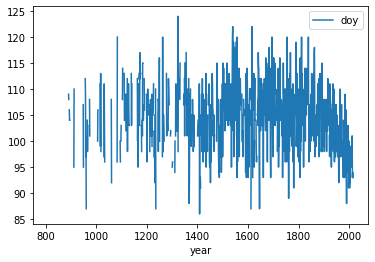

In [192]:
d.plot(x='year', y='doy')